# Demonstration of basic functions  


## Examples

This tutorial provides examples to show the basic features of CSSRlib for Standalone, RTK.

- Visualizing orbit of QZSS satellite
- Showing skyplot
- Standalone positioning
- RTK positioning

Note that despite the static setup
of the antenna, all data sets are processed assuming a non-stationary antenna. A motion model has not been used for the
receiver position. Instead, a sufficiently large amount of process noise has been added to the variance of the predicted position
states.

Click on the arrows in the left margin to open or close an example

## Example 1: Visualizing the Orbit of a Satellite

In this first example, we will introduce the basic features of CSSRlib to calculate and visualize a QZSS satellite orbit.

First, we will load the required Python modules such as numpy, matplotlib,  and cartopy. Then we will load modules from CSSRlib.

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

from cssrlib.rinex import rnxdec
from cssrlib.gnss import Nav, epoch2time, prn2sat, uGNSS, sat2prn,\
    timeadd, ecef2pos
from cssrlib.ephemeris import findeph, eph2pos

In CSSRlib, the epoch is defined as Python Class `gtime_t` as in RTKlib. The snippet defines epoch "19/3/2021 0:00:00", shows the internal variable of `gtime_t`.

In [8]:
t0 = epoch2time([2021, 3, 19, 0, 0, 0]) # year, month, day, hour, minute, sec
t0.time,t0.sec

(1616112000, 0)

Then, the ephemeris in RINEX format is loaded using RINEX decoder in CSSRlib.

In [30]:
dec = rnxdec()
nav = dec.decode_nav( 'cssrlib-data/data/doy2021-078/30340780.21q', Nav()) # load RINEX navigation file

The satellites are identified by the system (GPS, Galileo, QZS, ...) and by PRN number. They should be converted into the internal satellite numbers using prn2sat. This snippet shows the satellite number for QZSS with PRN 194 (QZS-2):

In [11]:
sat = prn2sat(uGNSS.QZS, 194)
sat

70

The orbit position of a GNSS satellite can be calculated using ephemeris defined in the RINEX navigation file. The valid ephemeris for a specific epoch can be searched for using `findeph`. Position and velocity in ECEF and clock bias are calculated by eph2pos. The position in geodetic cordinates can be calculated by ecef2pos:

In [12]:
t = t0
eph = findeph(nav.eph, t, sat)
rs, vs, dts = eph2pos(t, eph, True)
print('rs=',rs, 'vs=', vs,'dts=', dts)
pos = ecef2pos(rs)
print('pos=',pos)

rs= [-27695465.67390223  25576355.5431149   23733383.2869802 ] vs= [ 618.82498925 -271.15881898 1281.49729409] dts= 3.4869334074196084e-06
pos= [5.62300943e-01 2.39595272e+00 3.81752334e+07]


The orbit of QZS-2 for 1 day (24 hours) is calculated and plotted using Cartopy:

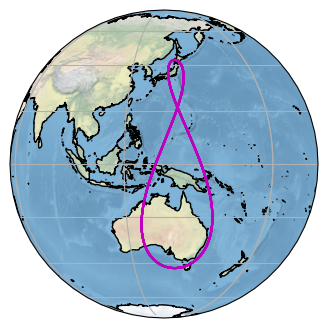

In [13]:
lon0 = 135
plt.figure(figsize=(4, 4))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=lon0,
                                           central_latitude=0))
ax.coastlines(resolution='50m')
ax.gridlines()
ax.stock_img()

n = 24*3600//300
pos = np.zeros((n, 3))
r2d = 180/np.pi

for k in range(uGNSS.MAXSAT):
    sat = k+1
    sys, prn = sat2prn(sat)
    if sys != uGNSS.QZS:  # skip non QZSS
        continue
    for i in range(n):
        t = timeadd(t0, i*300)
        if eph is None:
            continue
        rs, dts = eph2pos(t, eph)
        pos[i, :] = ecef2pos(rs)

    plt.plot(pos[:, 1]*r2d, pos[:, 0]*r2d, 'm-', transform=ccrs.Geodetic())
plt.show()

## Example 2: Showing a Skyplot

For the visualization of measurements, CSSRlib supports the skyplots of satellite orbit paths at specific locations. At first, the required modules are loaded.

In [14]:
import numpy as np
from cssrlib.gnss import Nav, ecef2pos, geodist, satazel, timediff, uGNSS, rSigRnx
from cssrlib.ephemeris import findeph, eph2pos
from cssrlib.plot import skyplot, plot_elv
from cssrlib.rinex import rnxdec

Then, an instance of a RINEX decoder is generated. In this example, the observation and navigation files measured by a Septentrio Mosaic-X5 receiver are used. We also need to specify which satellite signals will be used.

In [15]:
navfile = 'cssrlib-data/data/doy2021-078/SEPT078M.21P'
obsfile = 'cssrlib-data/data/doy2021-078/SEPT078M.21O'

dec = rnxdec()
nav = dec.decode_nav(navfile,Nav())

sigs = [rSigRnx("GC1C"), rSigRnx("EC1C"), rSigRnx("JC1C")]
dec.setSignals(sigs)

Next, the orbit of tracked satellites is calculated for 15 minutes of epoch.

In [16]:
nep = 15*60  # 15 minutes
elv = np.ones((nep, uGNSS.MAXSAT))*np.nan
azm = np.ones((nep, uGNSS.MAXSAT))*np.nan
t = np.zeros(nep)*np.nan

if dec.decode_obsh(obsfile) >= 0:
    rr = dec.pos
    pos = ecef2pos(rr)
    for ne in range(nep):
        print('\repoch=%d/%d' % (ne, nep), end='')
        obs = dec.decode_obs()
        if ne == 0:
            t0 = obs.t
        t[ne] = timediff(obs.t, t0)
        for k, sat in enumerate(obs.sat):
            eph = findeph(nav.eph, obs.t, sat)
            if eph is None:
                continue
            rs, dts = eph2pos(obs.t, eph)
            r, e = geodist(rs, rr)
            azm[ne, sat-1], elv[ne, sat-1] = satazel(pos, e)
    dec.fobs.close()

epoch=899/900

The elevation and azimuth angles of each satellite are recorded, and the skyplot is generated as below:

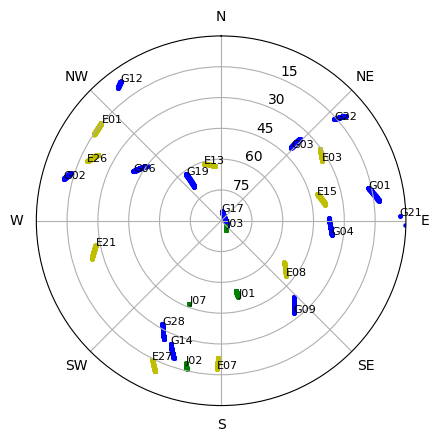

In [17]:
#plot_elv(t, elv)
nsat = skyplot(azm, elv)

## Example 3: Standalone positioning

This section introduces standalone GNSS positioning using RINEX observations from a Septentrio Mosaic-X5 receiver.

First, the required Python modules are loaded.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from cssrlib.rinex import rnxdec
from cssrlib.gnss import ecef2pos, timediff, dops, ecef2enu, rSigRnx, Nav
from cssrlib.pntpos import stdpos

Then the rover position is defined for reference.

In [19]:
xyz_ref = [-3962108.6726, 3381309.4719, 3668678.6264]
pos_ref = ecef2pos(xyz_ref)

RINEX navigation and observation files are defined, an instance of RINEX decoder is generated, and satellite signals are specified.

In [20]:
navfile = 'cssrlib-data/data/doy2023-223/NAV223.23p'
obsfile = 'cssrlib-data/data/doy2023-223/SEPT223Y.23O'  # PolaRX5
dec = rnxdec()
nav = dec.decode_nav(navfile, Nav(nf=1))
nav.pmode = 0

sigs = [rSigRnx("GC1C"), rSigRnx("EC1C"), rSigRnx("JC1C"),
        rSigRnx("GL1C"), rSigRnx("EL1C"), rSigRnx("JL1C"),
        rSigRnx("GS1C"), rSigRnx("ES1C"), rSigRnx("JS1C")]
dec.setSignals(sigs)
dec.autoSubstituteSignals()

The variables for position, DOPs, and number of satellite are defined for 6 minutes epoch.

In [21]:
nep = 6*60  # 6 minutes
t = np.zeros(nep)
enu = np.zeros((nep, 3))
dop = np.zeros((nep, 4))
nsat = np.zeros(nep, dtype=int)

std = stdpos(nav, dec.pos, 'test_stdpos.log')
sol = np.zeros((nep, nav.nx))

The standalone GNSS positioning by `std.process()` is conducted for 6 minutes.

In [22]:
if dec.decode_obsh(obsfile) >= 0:
    nav.x[0:3] = dec.pos
    for ne in range(nep):
        print('\repoch=%d/%d' % (ne, nep), end='')
        obs = dec.decode_obs()
        if ne == 0:
            t0 = nav.t = obs.t
        t[ne] = timediff(obs.t, t0)
        # nav, az, el = pntpos(obs, nav)
        std.process(obs, cs=None)
        sol[ne, :] = nav.x
        dop[ne, :] = std.dop
        enu[ne, :] = ecef2enu(pos_ref, sol[ne, 0:3]-xyz_ref)
        #nsat[ne] = len(el)
    dec.fobs.close()

epoch=359/360

The ENU position relative to the reference position is plotted.

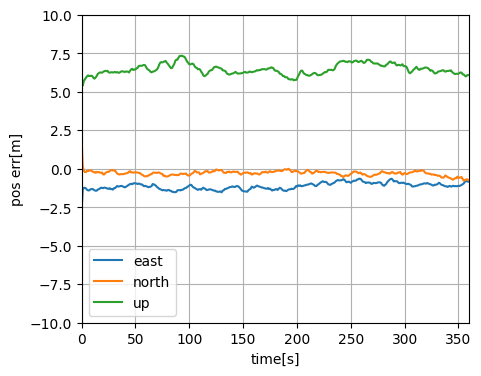

In [23]:
def plt_enu(t, enu, dmax=0.4):
    plt.figure(figsize=(5,4))
    plt.plot(t, enu)
    plt.ylabel('pos err[m]')
    plt.xlabel('time[s]')
    plt.legend(['east', 'north', 'up'])
    plt.grid()
    plt.axis([0, nep, -dmax, dmax])
    plt.show()

plt_enu(t, enu, 10)

To measure the geometry for positioning, DOPs (PDOP, HDOP, VDOP) are plotted:

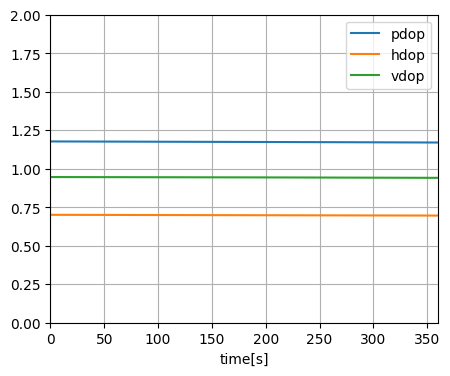

In [24]:
def plt_dop(t, dop):
    nep = len(t)
    plt.figure(figsize=(5,4))
    plt.plot(t, dop)
    plt.legend(['pdop', 'hdop', 'vdop'])
    plt.grid()
    plt.axis([0, nep, 0, 2])
    plt.xlabel('time[s]')
    plt.show()

plt_dop(t,dop[:,1:])

## Example 4: RTK positioning

This section demonstrates static RTK positioning under open-sky conditions using a Septentrio Mosaic-X5 rover and a Trimble Net-R9 base. The results are obtained using dual-frequency pseudorange and carrier-phase observations of GPS, Galileo and QZSS.  

First, load the required Python modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from cssrlib.rinex import rnxdec, sync_obs
from cssrlib.gnss import rSigRnx, Nav, time2str, ecef2pos, ecef2enu, epoch2time, time2doy, timediff
from cssrlib.peph import atxdec, searchpcv
from cssrlib.rtk import rtkpos
from cssrlib.plot import plot_enu

Define the reference position of the rover for evaulation.

In [2]:
xyz_ref = [-3962108.6836, 3381309.5672, 3668678.6720]
pos_ref = ecef2pos(xyz_ref)

Specify the satellite signals to be processed for base and rover. We choose L1C/A, L2P(Y) for GPS, E1, E5a for Galileo, L1C/A, L2C(L) for QZSS.

In [3]:
sigs = [rSigRnx("GC1C"), rSigRnx("GC2W"),
        rSigRnx("EC1C"), rSigRnx("EC5Q"),
        rSigRnx("JC1C"), rSigRnx("JC2L"),
        rSigRnx("GL1C"), rSigRnx("GL2W"),
        rSigRnx("EL1C"), rSigRnx("EL5Q"),
        rSigRnx("JL1C"), rSigRnx("JL2L"),
        rSigRnx("GS1C"), rSigRnx("GS2W"),
        rSigRnx("ES1C"), rSigRnx("ES5Q"),
        rSigRnx("JS1C"), rSigRnx("JS2L")]

Load the measurement and ephemeris data for the rover (Septentrio Mosaic-X5).

In [4]:
# Start epoch, number of epochs
ep = [2025, 8, 21, 7, 0, 0] # year, month, day, hour, min, sec

time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))
let = chr(ord('a')+ep[3])
bdir = f'cssrlib-data/data/doy{ep[0]:04d}-{doy:03d}/'
navfile = bdir+f'{doy:03d}{let}_rnx.nav'
obsfile = bdir+f'{doy:03d}{let}_rnx.obs'

# rover
dec = rnxdec()
dec.setSignals(sigs)
nav = Nav()
dec.decode_nav(navfile, nav)
dec.decode_obsh(obsfile)
dec.autoSubstituteSignals()

For RTK positioning, the observation file for the base station also needs to be specified, as well as the position of the base station.

In [5]:
# base station
station_id = '3034'  # GSI 3034 fujisawa
nav.rb = [-3959400.6242, 3385704.4927, 3667523.1257]  # GSI 3034 fujisawa

basefile = bdir+f'{station_id}{doy}{let}.{year%100:02d}o'
decb = rnxdec()
decb.setSignals(sigs)
decb.decode_obsh(basefile)
decb.autoSubstituteSignals()

Load the antenna data for the satellites and receivers

In [6]:
atxfile = bdir + '../antex/igs20.atx'
ngsantfile = bdir + '../GSI_PCV.TXT'

atx = atxdec()
atx.readpcv(atxfile)
atx.readngspcv(ngsantfile)

# Set PCO/PCV information
nav.rcv_ant = searchpcv(atx.pcvr, dec.ant,  dec.ts)
nav.rcv_ant_b = searchpcv(atx.pcvr, decb.ant,  dec.ts)

# Get equipment information
print(f"[Rover] Receiver: {dec.rcv} Antenna: {dec.ant}")
print(f"[Base]  Receiver: {decb.rcv} Antenna: {decb.ant}")

[Rover] Receiver: SEPT MOSAICX5        Antenna: JAVRINGANT_DM   JVDM
[Base]  Receiver: TRIMBLE ALLOY        Antenna: TRM159900.00    GSI6


Initialize the variables for position and the RTK configuration parameters.

In [7]:
rtk = rtkpos(nav, dec.pos, 'test_rtk.log')
rr = dec.pos

Run RTK positioning for 3 minutes (epochs) using `rtk.process()`.

In [8]:
nep = 3 * 60  # 3 minutes
t = np.zeros(nep)
enu = np.zeros((nep, 3))
smode = np.zeros(nep, dtype=int)

for ne in range(nep):
    obs, obsb = sync_obs(dec, decb)
    if ne == 0:
        t0 = nav.t = obs.t
    rtk.process(obs, obsb=obsb)
    t[ne] = timediff(nav.t, t0)
    sol = nav.xa[0:3] if nav.smode == 4 else nav.x[0:3]
    enu[ne, :] = ecef2enu(pos_ref, sol-xyz_ref)
    smode[ne] = nav.smode
    # Log to standard output
    sys.stdout.write('\r {} ENU {:7.4f} {:7.4f} {:7.4f}, 2D {:6.4f}, mode {:1d}'
                     .format(time2str(obs.t),
                             enu[ne, 0], enu[ne, 1], enu[ne, 2],
                             np.sqrt(enu[ne, 0]**2+enu[ne, 1]**2),
                             smode[ne]))

dec.fobs.close()
decb.fobs.close()

 2025-08-21 07:03:00 ENU  0.0007  0.0058 -0.0656, 2D 0.0059, mode 4

Plot the position relative to the reference position.

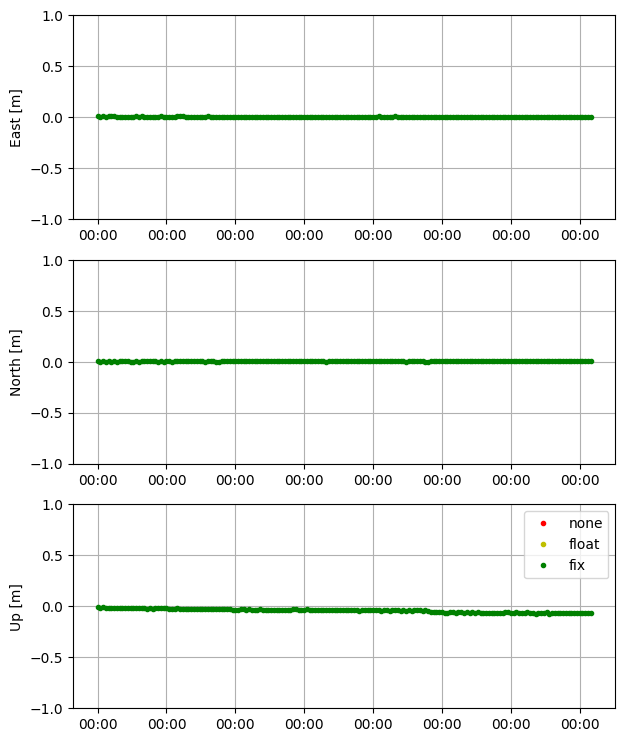

In [9]:
from cssrlib.plot import plot_enu

plot_enu(t, enu, smode)

## Reference

- [^1] T. Takasu, “RTKLIB: Open Source Program Package for RTK-GPS,” FOSS4G 2009 Tokyo, Japan, 2009.
- [^2] Hirokawa, R., Hauschild, A., Everett, T. (2023). Python Toolkit for Open PPP/PPP-RTK Services. In *Proceedings of the 35th International Technical Meeting of the Satellite Division of The Institute of Navigation (ION GNSS+ 2023)*
- [^3] Hirokawa, R., Hauschild, A. (2025). CSSRlib: Python Toolkit for High-Accuracy, Secure, and Resilient Positioning Services. In *Proceedings of the 37th International Technical Meeting of the Satellite Division of The Institute of Navigation (ION GNSS+ 2025)*